Dataset retrieval FFHQ DataSet from NVidia Labs

In [ ]:
!git clone https://github.com/NVlabs/ffhq-dataset

Cloning into 'ffhq-dataset'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 67 (delta 2), reused 4 (delta 2), pack-reused 60
Unpacking objects: 100% (67/67), done.


In [ ]:
!cd ffhq-dataset && python download_ffhq.py -t 

In [1]:
!mkdir FFHQ-TRAIN && mkdir FFHQ-TEST && mkdir FFHQ-DATA
!rm -r sample_data

In [4]:
!rm -r FFHQ-TEST && rm -r  FFHQ-TRAIN && rm -r FFHQ-DATA

Utils

Via Github/ Local Downloading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import os
import shutil
from tqdm import tqdm

def download_files(limit):
    source_dir = 'drive/MyDrive/thumbnails128x128/'
    target_dir = 'FFHQ-DATA'
        
    folder_names = os.listdir(source_dir)
    folder_names.remove('LICENSE.txt')

    i = 0

    for folder in tqdm(folder_names):

        files = os.listdir(source_dir + folder)
        for file_ in files:
          if limit and i == limit:
            break
          else:
            shutil.copy(os.path.join(source_dir + '/' + folder, file_), target_dir)
            i+=1
        if limit and i == limit:
            break

def index_files(source_dir):
    idx = 0
    photos = sorted(os.listdir(source_dir))

    for file_ in photos:
      os.rename(source_dir+'/'+file_, source_dir + '/' + str(idx) + '.png')
      #print(file_, source_dir + '/' + str(idx) + '.png')
      idx+=1

    # print(f'FILES IN {source_dir}: {len(os.listdir(source_dir))}')



def train_test_split():
    source_dir = 'FFHQ-DATA'
    samples = sorted(os.listdir(source_dir))


    target_train_dir = 'FFHQ-TRAIN/'
    target_test_dir = 'FFHQ-TEST/'

    for idx in range(int(len(samples) * 9.5/10)):
        shutil.copy(os.path.join(source_dir, samples[idx]), target_train_dir)
    
    for idx in range(int(len(samples) * 9.5/10), len(samples)):
        shutil.copy(os.path.join(source_dir, samples[idx]), target_test_dir)

target_train_dir = 'FFHQ-TRAIN'
target_test_dir = 'FFHQ-TEST'
original_dir = 'FFHQ-DATA'


download_files(limit=45100)
train_test_split()
index_files(target_train_dir)
index_files(target_test_dir)

print('\n\n')
print(f'FILES IN {target_train_dir}: {len(os.listdir(target_train_dir))}')
print(f'FILES IN {target_test_dir}: {len(os.listdir(target_test_dir))}')


 64%|██████▍   | 45/70 [12:53<07:09, 17.18s/it]





FILES IN FFHQ-TRAIN: 42845
FILES IN FFHQ-TEST: 2255


Dataset

In [16]:
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
from skimage.color import rgb2lab, rgb2gray, lab2rgb

transforms = T.Compose([
      T.ToTensor(),
      T.ConvertImageDtype(torch.float)
    ])

to_pil_transform = T.Compose([
    T.ToPILImage()
])


def transform(rgb_img, transforms=None):
  lab_image = (rgb2lab(np.array(rgb_img)) + 128) / 255 # normalization

  ab_img = lab_image[:,:, 1:3] # A,B channels  --- (128,128,2)
  gray_img = np.expand_dims(rgb2gray(np.array(rgb_img)), 2) #(L)uminosity channel  --- (128,128,1)

  if transforms:
    return transforms(gray_img), transforms(rgb_img), transforms(ab_img)#input, final_target, ab_target
  return gray_img, rgb_img, ab_img 

def reconstruct_img(ab_img, gray_img):

  recon_img = torch.cat((gray_img, ab_img), 0).detach().cpu().numpy()

  recon_img[0:1,:,:] = recon_img[0:1,:,:] * 100
  recon_img[1:3:,:,] = recon_img[1:3,:,:] * 255 - 128
  recon_img = np.swapaxes(recon_img, 0, -1)

  reconstruct_rgb = torch.swapaxes(torch.from_numpy(lab2rgb(recon_img)), 0, -1)

  return to_pil_transform(reconstruct_rgb)


class FFHQ_Dataset(Dataset):
    def __init__(self, IMG_DIR='FFHQ-DATA', transform=None) -> None:
        super().__init__()
        self.IMG_DIR = IMG_DIR
        self.transform = transform

    def __len__(self) -> int:
        import os
        return len(os.listdir(self.IMG_DIR))

    def __getitem__(self, idx) -> Image:
        import os
        found = 0
        for photo in os.listdir(self.IMG_DIR):
            if photo == (str(idx) + '.png'):
                img = Image.open(self.IMG_DIR + '/' + photo)
                found = 1
                break
        if not found:
            raise ValueError(f"The image with the index {idx} not found in the dataset")
              
        return self.transform(img, transforms=transforms)
    
    def __show__(self, idx, transform):
      if transform:
        img = transform(self.__getitem__(idx))
      else:
        img = self.__getitem__(idx)
      img

train_dataset = FFHQ_Dataset(IMG_DIR='FFHQ-TRAIN', transform=transform)
test_dataset = FFHQ_Dataset(IMG_DIR='FFHQ-TEST', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

MODEL

In [ ]:
#AutoEncoder Arhitecture : Encoder + Decoder 
#Encoder: VGG 16 pre-trained / ResNet
#Decoder: Custum decoder with 3x CNN Blocks

########################################### VGG Model ###########################################


import torch.nn as nn
import torch.hub



VGG_16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
VGG_19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

VGG_19bn_url = 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth'
VGG_16bn_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
VGG_19_url = "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth"
VGG_16_url = "https://download.pytorch.org/models/vgg16-397923af.pth"

def creat_CNNBlock(in_channels, out_channels, kernel_size, use_bn, use_act=True,**kwargs):
  CNNBlock = [
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, **kwargs),  
            nn.BatchNorm2d(out_channels) if use_bn else nn.Identity(),  
            nn.ReLU(inplace=True) if use_act else nn.Identity(),               
        ]
  
  return CNNBlock

class VGG(nn.Module):
  def __init__(self, config, url, use_bn=True):
    super().__init__()
    self.config = config
    self.use_bn = use_bn
    self.model = self.create_model()
    if url:
      self.load_pretrained_weights(url)
    
  
  def create_model(self):
    in_channels = 1
    self.layers = []
    for l in self.config:
      if l == 'M':
          self.layers.extend([nn.MaxPool2d(kernel_size=2, stride=2)])
      else:
          self.layers.extend(creat_CNNBlock(in_channels, l, kernel_size=3, use_bn=self.use_bn, padding=1))
          in_channels = l

    return nn.Sequential(*self.layers)

  def load_pretrained_weights(self, url):
    state_dict = torch.hub.load_state_dict_from_url(url)
    self.model.load_state_dict(state_dict, strict=False)

  def forward(self, input):
    return self.model(input)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg = VGG(VGG_19_config, VGG_19_url, use_bn=False)

vgg.to(device)
print(device)

In [7]:
# VGG output: torch.Size([16, 512, 4, 4])
## DECODER: conv block: [conv(512 -> 128), batch norm, relu] ± UpSample

##

def creat_CNNBlock(in_channels, out_channels, kernel_size, use_bn, use_act='relu',**kwargs):

  CNNBlock = [
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, **kwargs),  
            nn.BatchNorm2d(out_channels) if use_bn else nn.Identity(),               
        ]
  if use_act=='relu':
      CNNBlock += [nn.ReLU(inplace=True)]
  elif use_act=='tanh':
      CNNBlock += [nn.Tanh()]
  else:
    return CNNBlock
  return CNNBlock

  

decoder_config = [256, 128, 'U', 64, 'U', 32, 'U', 16, 'U', 2, 'U']
act = 5*['relu'] + ['tanh']
bn = 5*[True] + [False]

class Decoder(nn.Module):
  def __init__(self, config, use_bn) -> None:
      super().__init__()
      self.config = config
      self.bn = use_bn
      self.model = self.create_model()


  def create_model(self):
    in_channels = 512
    self.layers = []
    idx = 0
    for l in self.config:
      if l == 'U':
          self.layers.extend([nn.Upsample(scale_factor=2)])
      else:
          self.layers.extend(creat_CNNBlock(in_channels, l, kernel_size=3, use_act=act[idx], use_bn=self.bn[idx], padding=1))
          in_channels = l
          idx+=1

    return nn.Sequential(*self.layers)

  def forward(self, input):
    return self.model(input)
    
decoder = Decoder(decoder_config, use_bn=bn)
decoder.to(device)


Decoder(
  (model): Sequential(
    (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Upsample(scale_factor=2.0, mode=nearest)
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Upsample(scale_factor=2.0, mode=nearest)
    (11): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Upsample(scale_factor=2.0, mode=nearest)
    (15): Conv2d(32, 16, kernel_size=(

In [40]:
from torch.optim import Adam
from torch.nn import MSELoss
from tqdm import tqdm

for param in vgg.parameters():
  param._requier_grad = False


to_pil_transform = T.Compose([
    T.ToPILImage()
])


optimizer = Adam(decoder.parameters(), lr=0.001)
mse_loss = MSELoss()


def train_one_epoch(epoch): # returns the mean loss over the specific epoch  
  total_loss = 0
  print(f'Training... epoch {epoch}')
  loop = tqdm(train_dataloader, leave=True)
  decoder.model.train()

  for idx, batch in enumerate(loop):

    batch = [sample.to(device) for sample in batch]

    gray_input, rgb_target, ab_target = batch

    decoder.model.zero_grad()
    ab_output = decoder.forward(vgg.forward(gray_input))

    loss = mse_loss(ab_output, ab_target)

    #backpropagation 
    loss.backward()
    optimizer.step()

    #gpu memory cleaning 
    loss = loss.detach().cpu().numpy()
    ab_output = ab_output.detach().cpu().numpy()
    batch = [sample.detach().cpu().numpy() for sample in batch]

    total_loss+=loss

    loop.set_description(f'Loss for the epoch {epoch}: {loss}')



  return total_loss/len(train_dataloader)

def test_one_epoch(epoch): # returns the mean loss over the specific epoch  
  total_loss = 0
  print(f'Testing... epoch {epoch}')
  decoder.model.eval()
  loop = tqdm(test_dataloader, leave=True)

  for idx, batch in enumerate(loop):

    batch = [sample.to(device) for sample in batch]

    gray_input, rgb_target, ab_target = batch

    with torch.no_grad():
      decoder.model.zero_grad()
      ab_output = decoder.forward(vgg.forward(gray_input))

      loss = mse_loss(ab_output, ab_target)
      loss = loss.detach().cpu().numpy()
      total_loss+=loss

      ab_output = ab_output.detach().cpu().numpy()  
      batch = [sample.detach().cpu().numpy() for sample in batch]

    loop.set_description(f'Loss for the epoch {epoch}: {loss}')


  return total_loss/len(test_dataloader)  



train_losses = [0.0026]
test_losses = [0.0024]

def train_for_image_colorization_AE(num_epochs, base=True):
  if base:
    decoder.model.load_state_dict(torch.load('image_colorization_AE.pt'),strict=False)

  best_loss = float('inf')
  for epoch in range(1, num_epochs):

    print(f'EPOCH no {epoch}')

    train_loss = train_one_epoch(epoch)
    test_loss = test_one_epoch(epoch)
    print(train_loss, test_loss)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    if test_loss < best_loss:
      torch.save(decoder.state_dict(), 'image_colorization_AE.pt') 
      best_loss = test_loss

    #overfitting

    if epoch >= 3:
      mean_loss = sum(train_losses[epoch-3:epoch])/3
      if mean_loss > train_losses[epoch-3]:
        print("Overfitting detected")


train_for_image_colorization_AE(10)


EPOCH no 1
Training... epoch 1


Loss for the epoch 1: 0.002424078295007348: 100%|██████████| 10712/10712 [1:05:19<00:00,  2.73it/s]


Testing... epoch 1


Loss for the epoch 1: 0.0025905841030180454: 100%|██████████| 564/564 [01:19<00:00,  7.12it/s]


0.0025570161939865795 0.0024838447605890508
EPOCH no 2
Training... epoch 2


Loss for the epoch 2: 0.002064849715679884:   0%|          | 25/10712 [00:09<1:05:29,  2.72it/s]


KeyboardInterrupt: ignored

In [42]:
train_losses, test_losses


([0.0026, 0.0025570161939865795], [0.0024, 0.0024838447605890508])

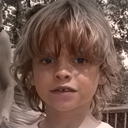

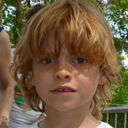

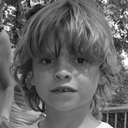

In [87]:
decoder.model.load_state_dict(torch.load('image_colorization_AE.pt'),strict=False)



for idx, batch in enumerate(test_dataloader):

    batch = [sample.to(device) for sample in batch]

    gray_input, rgb_target, ab_target = batch

    with torch.no_grad():
      decoder.model.zero_grad()
      ab_output = decoder.forward(vgg.forward(gray_input))
      #print(ab_output.size(), gray_input.size())
      display(reconstruct_img(ab_output[0], gray_input[0]))  
      display(reconstruct_img(ab_target[0], gray_input[0]))
      display(to_pil_transform(gray_input[0].detach().cpu()))

    break    
